# Without Unnecessary Column Names + Grid Search

In [63]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt

# Load data
file_path = 'data/enepk_report.xlsx'
# data = pd.read_excel(file_path)
data = pd.read_excel(file_path, header=[0, 1, 2])

# Flatten multi-level columns
data.columns = data.columns.map(' '.join).str.strip()

# Display the columns to identify the unnecessary ones
print(data.columns.tolist())

['Unnamed: 0_level_0 Year Unnamed: 0_level_2', 'Unnamed: 1_level_0 Month Unnamed: 1_level_2', 'Monthly Actual NEL (GWh)', 'Pct Chg Month Prior Yr', 'Y-T-D NEL (GWh)', 'Y-T-D Pct Chg Prior Yr', '12 Mo Rolling  NEL (GWh)', 'Pct Chg 12-Mo Roll Prior Yr', 'Pct Chg Normalized  NEL (GWh)', 'Pct Chg Normal Prior Yr', 'Y-T-D Normal (GWh)', 'Pct Chg Y-T-D Prior Yr', '12 Month  Rolling Normal GWh', 'Pct Chg 12-Mo Roll Prior Yr.1', 'Pct Chg Monthly tCDD', 'Pct Chg Monthly HDD', 'Total Adjmnts GWh', 'Weather Adjmnt GWh', 'NonH- Wdys adj', 'Leap  Year Adj.', 'Monthly Peak MW', 'Pct Chg Peak Prior Year', 'Pct Chg Pk Date', 'Pct Chg Pk Hour', 'Pct Chg Pk Temp', 'Pct Chg Pk DPt', 'Pct Chg Month Unnamed: 26_level_2', 'Pct Chg Year Unnamed: 27_level_2', 'Pct Chg Year Revisions', 'Pct Chg Year Remarks']


In [64]:
# Create a directory to save the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

In [65]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate MBD
def mean_bias_deviation(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Function to calculate sMAPE
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

In [66]:
# Drop unnecessary columns
columns_to_drop = [
    'Pct Chg Month Unnamed: 26_level_2', 
    'Pct Chg Year Unnamed: 27_level_2', 
    'Pct Chg Year Revisions', 
    'Pct Chg Year Remarks'
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Rename columns for easier access
column_names = [
    'Year', 'Month', 'Actual NEL (GWh)', 'Pct Chg Month Prior Yr', 'Y-T-D NEL (GWh)', 'Y-T-D Pct Chg Prior Yr', 
    '12 Mo Rolling NEL (GWh)', 'Pct Chg 12-Mo Roll Prior Yr', 'Pct Chg Normalized NEL (GWh)', 'Pct Chg Normal Prior Yr', 
    'Y-T-D Normal (GWh)', 'Pct Chg Y-T-D Prior Yr', '12 Month Rolling Normal GWh', 'Pct Chg 12-Mo Roll Prior Yr.1', 
    'Pct Chg Monthly tCDD', 'Pct Chg Monthly HDD', 'Total Adjmnts GWh', 'Weather Adjmnt GWh', 'NonH-Wdys adj', 
    'Leap Year Adj.', 'Monthly Peak MW', 'Pct Chg Peak Prior Year', 'Pct Chg Pk Date', 'Pct Chg Pk Hour', 'Pct Chg Pk Temp', 'Pct Chg Pk DPt'
]

# Ensure the number of columns matches
if len(column_names) == len(data.columns):
    data.columns = column_names
else:
    print(f"Column length mismatch: Expected {len(column_names)} columns, but got {len(data.columns)} columns")

# Convert data types
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

# Convert month names to numeric
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
data['Month'] = data['Month'].map(month_map)

# Handle missing values
data = data.dropna(subset=['Year', 'Month'])

# Display the cleaned data
print(data.head())


     Year  Month  Actual NEL (GWh)  Pct Chg Month Prior Yr  Y-T-D NEL (GWh)  \
0  2024.0    6.0          10109.63                0.096304         56666.12   
1  2024.0    5.0           8629.20                0.050171         46556.49   
2  2024.0    4.0           8292.49                0.019915         37927.29   
3  2024.0    3.0           9255.25               -0.018960         29634.80   
4  2024.0    2.0           9498.46                0.018437         20379.55   

   Y-T-D Pct Chg Prior Yr  12 Mo Rolling NEL (GWh)  \
0                0.038543                116826.72   
1                0.026796                115938.65   
2                0.021622                115526.40   
3                0.022101                115364.48   
4                0.041905                115543.35   

   Pct Chg 12-Mo Roll Prior Yr  Pct Chg Normalized NEL (GWh)  \
0                     0.005856                   9657.190000   
1                    -0.004218                   8337.545197   
2       

In [67]:
# # Define available features
# features = ['Year', 'Month', 'Actual NEL (GWh)', 'Monthly Peak MW', 'Total Adjmnts GWh', 'Weather Adjmnt GWh']  # Adjusted feature set
# target = 'Actual NEL (GWh)'

# # Split data based on years
# train_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2017)]
# error_correction_train_data = data[data['Year'] == 2018]
# test_data = data[data['Year'] == 2019]

# # Further split 2018 data for error correction module
# error_correction_train, error_correction_val = train_test_split(error_correction_train_data, test_size=0.2, random_state=42)

# # Separate features and target
# X_train = train_data[features]
# y_train = train_data[target]

# X_error_correction_train = error_correction_train[features]
# y_error_correction_train = error_correction_train[target]

# X_val = error_correction_val[features]
# y_val = error_correction_val[target]

# X_test = test_data[features]
# y_test = test_data[target]

# # Feature scaling
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_error_correction_train = scaler.transform(X_error_correction_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)

# # Model training for forecasting
# forecasting_model = RandomForestRegressor(n_estimators=100, random_state=42)
# forecasting_model.fit(X_train, y_train)

# # Error correction model
# error_correction_model = RandomForestRegressor(n_estimators=100, random_state=42)
# error_correction_model.fit(X_error_correction_train, y_error_correction_train)

# # Forecasting model evaluation on validation set
# y_val_forecast = forecasting_model.predict(X_val)
# val_forecast_mae = mean_absolute_error(y_val, y_val_forecast)
# val_forecast_mse = mean_squared_error(y_val, y_val_forecast)
# val_forecast_mape = mean_absolute_percentage_error(y_val, y_val_forecast)

# print(f'Validation MAE (Forecast): {val_forecast_mae}')
# print(f'Validation MSE (Forecast): {val_forecast_mse}')
# print(f'Validation MAPE (Forecast): {val_forecast_mape}')

# # Error correction model evaluation on validation set
# y_val_corrected = error_correction_model.predict(X_val)
# val_corrected_mae = mean_absolute_error(y_val, y_val_corrected)
# val_corrected_mse = mean_squared_error(y_val, y_val_corrected)
# val_corrected_mape = mean_absolute_percentage_error(y_val, y_val_corrected)

# print(f'Validation MAE (Error Correction): {val_corrected_mae}')
# print(f'Validation MSE (Error Correction): {val_corrected_mse}')
# print(f'Validation MAPE (Error Correction): {val_corrected_mape}')

# # Test the forecasting model
# y_test_forecast = forecasting_model.predict(X_test)
# test_forecast_mae = mean_absolute_error(y_test, y_test_forecast)
# test_forecast_mse = mean_squared_error(y_test, y_test_forecast)
# test_forecast_mape = mean_absolute_percentage_error(y_test, y_test_forecast)

# print(f'Test MAE (Forecast): {test_forecast_mae}')
# print(f'Test MSE (Forecast): {test_forecast_mse}')
# print(f'Test MAPE (Forecast): {test_forecast_mape}')

# # Test the error correction model
# y_test_corrected = error_correction_model.predict(X_test)
# test_corrected_mae = mean_absolute_error(y_test, y_test_corrected)
# test_corrected_mse = mean_squared_error(y_test, y_test_corrected)
# test_corrected_mape = mean_absolute_percentage_error(y_test, y_test_corrected)

# print(f'Test MAE (Error Correction): {test_corrected_mae}')
# print(f'Test MSE (Error Correction): {test_corrected_mse}')
# print(f'Test MAPE (Error Correction): {test_corrected_mape}')

In [ ]:
# Define available features
features = ['Year', 'Month', 'Actual NEL (GWh)', 'Monthly Peak MW', 'Total Adjmnts GWh', 'Weather Adjmnt GWh']  
target = 'Actual NEL (GWh)'

# Split data based on years
train_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2017)]
error_correction_train_data = data[data['Year'] == 2018]
test_data = data[data['Year'] == 2019]

# Further split 2018 data for error correction module
error_correction_train, error_correction_val = train_test_split(error_correction_train_data, test_size=0.2, random_state=42)

# Separate features and target
X_train = train_data[features]
y_train = train_data[target]

X_error_correction_train = error_correction_train[features]
y_error_correction_train = error_correction_train[target]

X_val = error_correction_val[features]
y_val = error_correction_val[target]

X_test = test_data[features]
y_test = test_data[target]

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_error_correction_train = scaler.transform(X_error_correction_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [68]:
# Define parameter grid for GridSearchCV for randomforesting model
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV for randomforesting model
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3,
                              n_jobs=-1,
                              verbose=2)

# Perform grid search for randomforesting model
grid_search_rf.fit(X_train, y_train)

# Best hyperparameters for randomforesting model
best_params_rf = grid_search_rf.best_params_
print(f'Best parameters for randomforesting model: {best_params_rf}')

# Train the best randomforesting model
best_forecasting_model = RandomForestRegressor(**best_params_rf, random_state=42)
best_forecasting_model.fit(X_train, y_train)

# Randomforesting model evaluation on validation set
y_val_forecast = best_forecasting_model.predict(X_val)
val_forecast_mae = mean_absolute_error(y_val, y_val_forecast)
val_forecast_mse = mean_squared_error(y_val, y_val_forecast)
val_forecast_mape = mean_absolute_percentage_error(y_val, y_val_forecast)
val_forecast_rmse = rmse(y_val, y_val_forecast)
val_forecast_r2 = r2_score(y_val, y_val_forecast)
val_forecast_mbd = mean_bias_deviation(y_val, y_val_forecast)
val_forecast_smape = smape(y_val, y_val_forecast)

print(f'Validation MAE (Randomforest): {val_forecast_mae}')
print(f'Validation MSE (Randomforest): {val_forecast_mse}')
print(f'Validation MAPE (Randomforest): {val_forecast_mape}')
print(f'Validation RMSE (Randomforest): {val_forecast_rmse}')
print(f'Validation R² (Randomforest): {val_forecast_r2}')
print(f'Validation MBD (Randomforest): {val_forecast_mbd}')
print(f'Validation sMAPE (Randomforest): {val_forecast_smape}')

# Test the Randomforesting model
y_test_forecast = best_forecasting_model.predict(X_test)
test_forecast_mae = mean_absolute_error(y_test, y_test_forecast)
test_forecast_mse = mean_squared_error(y_test, y_test_forecast)
test_forecast_mape = mean_absolute_percentage_error(y_test, y_test_forecast)
test_forecast_rmse = rmse(y_test, y_test_forecast)
test_forecast_r2 = r2_score(y_test, y_test_forecast)
test_forecast_mbd = mean_bias_deviation(y_test, y_test_forecast)
test_forecast_smape = smape(y_test, y_test_forecast)

print(f'Test MAE (Randomforest): {test_forecast_mae}')
print(f'Test MSE (Randomforest): {test_forecast_mse}')
print(f'Test MAPE (Randomforest): {test_forecast_mape}')
print(f'Test RMSE (Randomforest): {test_forecast_rmse}')
print(f'Test R² (Randomforest): {test_forecast_r2}')
print(f'Test MBD (Randomforest): {test_forecast_mbd}')
print(f'Test sMAPE (Randomforest): {test_forecast_smape}')

# Define parameter grid for GridSearchCV for error correction model
param_grid_rfec = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV for error correction model
grid_search_rfec = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=param_grid_rfec,
                              cv=3,
                              n_jobs=-1,
                              verbose=2)

# Perform grid search for error correction model
grid_search_rfec.fit(X_error_correction_train, y_error_correction_train)

# Best hyperparameters for error correction model
best_params_rfec = grid_search_rfec.best_params_
print(f'Best parameters for error correction model: {best_params_rfec}')

# Train the best error correction model
best_rfec_model = RandomForestRegressor(**best_params_rfec, random_state=42)
best_rfec_model.fit(X_error_correction_train, y_error_correction_train)

# Error correction model evaluation on validation set
y_val_corrected = best_rfec_model.predict(X_val)
val_corrected_mae = mean_absolute_error(y_val, y_val_corrected)
val_corrected_mse = mean_squared_error(y_val, y_val_corrected)
val_corrected_mape = mean_absolute_percentage_error(y_val, y_val_corrected)
val_corrected_rmse = rmse(y_val, y_val_corrected)
val_corrected_r2 = r2_score(y_val, y_val_corrected)
val_corrected_mbd = mean_bias_deviation(y_val, y_val_corrected)
val_corrected_smape = smape(y_val, y_val_corrected)

print(f'Validation MAE (RF Error Correction): {val_corrected_mae}')
print(f'Validation MSE (RF Error Correction): {val_corrected_mse}')
print(f'Validation MAPE (RF Error Correction): {val_corrected_mape}')
print(f'Validation RMSE (RF Error Correction): {val_corrected_rmse}')
print(f'Validation R² (RF Error Correction): {val_corrected_r2}')
print(f'Validation MBD (RF Error Correction): {val_corrected_mbd}')
print(f'Validation sMAPE (RF Error Correction): {val_corrected_smape}')

# Test the error correction model
y_test_corrected = best_error_correction_model.predict(X_test)
test_corrected_mae = mean_absolute_error(y_test, y_test_corrected)
test_corrected_mse = mean_squared_error(y_test, y_test_corrected)
test_corrected_mape = mean_absolute_percentage_error(y_test, y_test_corrected)
test_corrected_rmse = rmse(y_test, y_test_corrected)
test_corrected_r2 = r2_score(y_test, y_test_corrected)
test_corrected_mbd = mean_bias_deviation(y_test, y_test_corrected)
test_corrected_smape = smape(y_test, y_test_corrected)

print(f'Test MAE (RF Error Correction): {test_corrected_mae}')
print(f'Test MSE (RF Error Correction): {test_corrected_mse}')
print(f'Test MAPE (RF Error Correction): {test_corrected_mape}')
print(f'Test RMSE (RF Error Correction): {test_corrected_rmse}')
print(f'Test R² (RF Error Correction): {test_corrected_r2}')
print(f'Test MBD (RF Error Correction): {test_corrected_mbd}')
print(f'Test sMAPE (RF Error Correction): {test_corrected_smape}')

Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for randomforesting model: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Validation MAE (Randomforest): 30.97166666666635
Validation MSE (Randomforest): 1447.8627083333286
Validation MAPE (Randomforest): 0.0030317018223012028
Validation RMSE (Randomforest): 38.05079116566866
Validation R² (Randomforest): 0.9935428438114162
Validation MBD (Randomforest): 30.96833333333355
Validation sMAPE (Randomforest): 0.30386910051637944
Test MAE (Randomforest): 89.33666666666689
Test MSE (Randomforest): 15316.690637500027
Test MAPE (Randomforest): 0.009505502898843372
Test RMSE (Randomforest): 123.76061828182674
Test R² (Randomforest): 0.9876977915859261
Test MBD (Randomforest): -60.91500000000011
Test sMAPE (Randomforest): 0.9420813881331603
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for error correction model: {'bootstrap': Fa

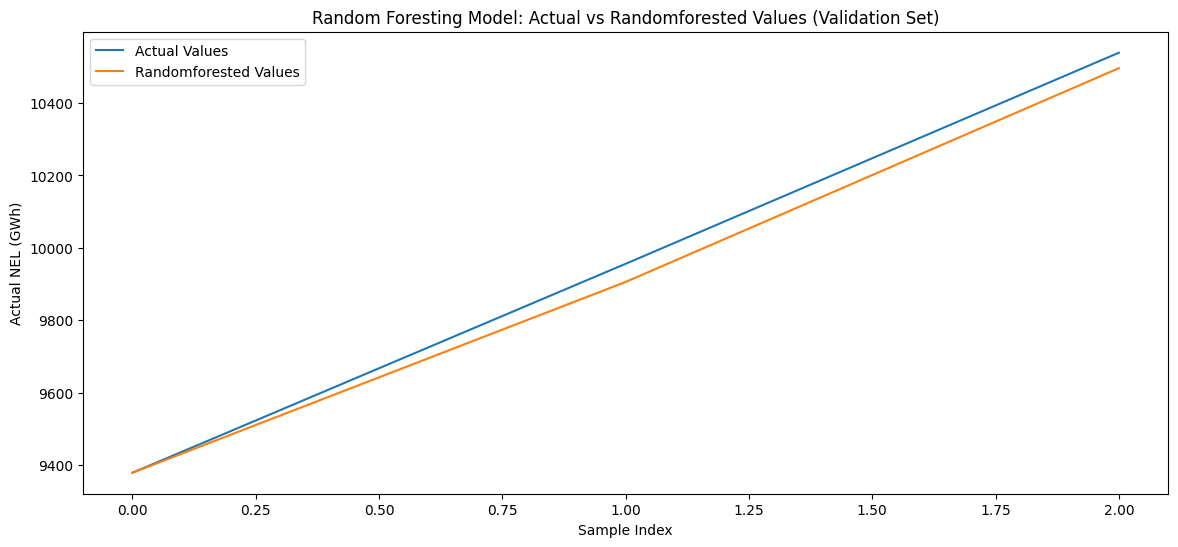

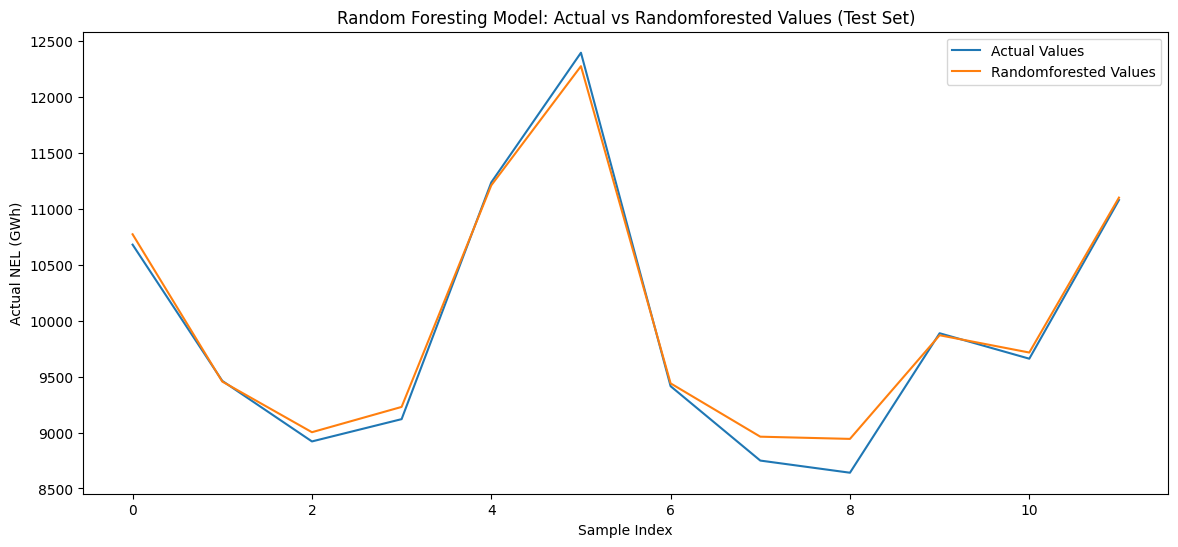

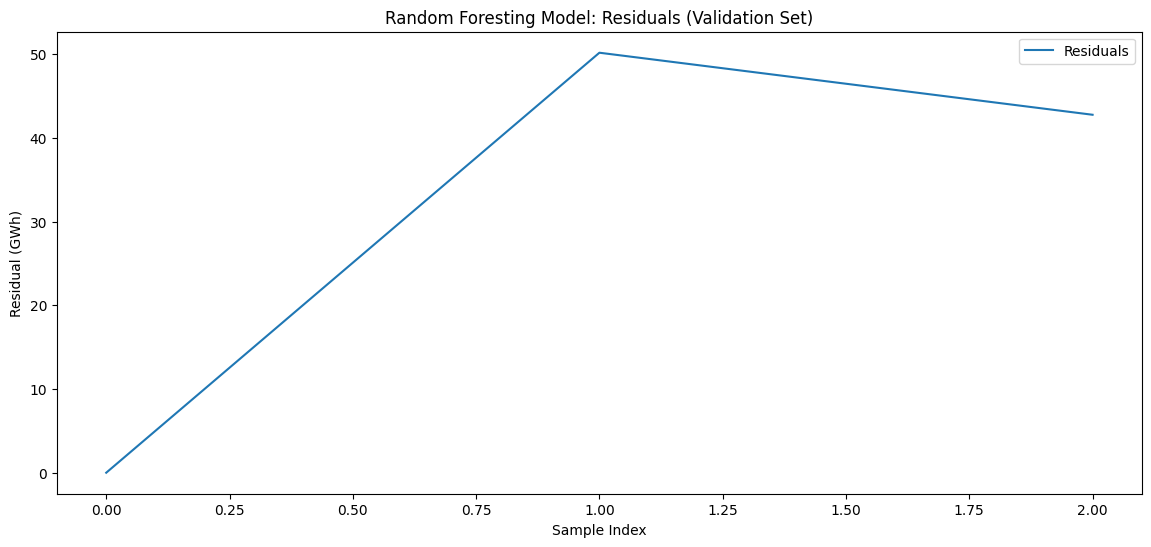

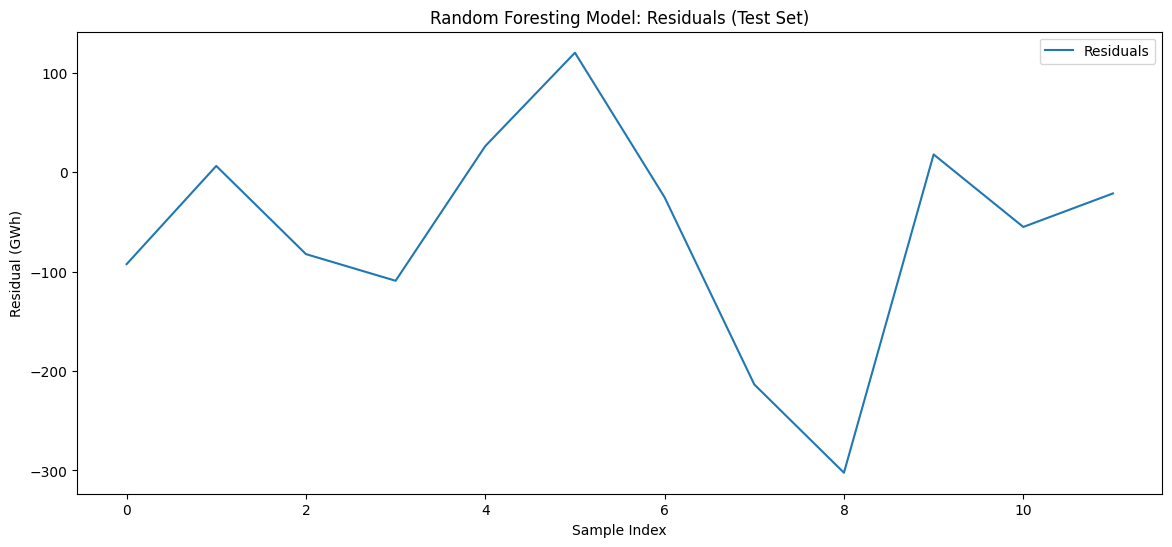

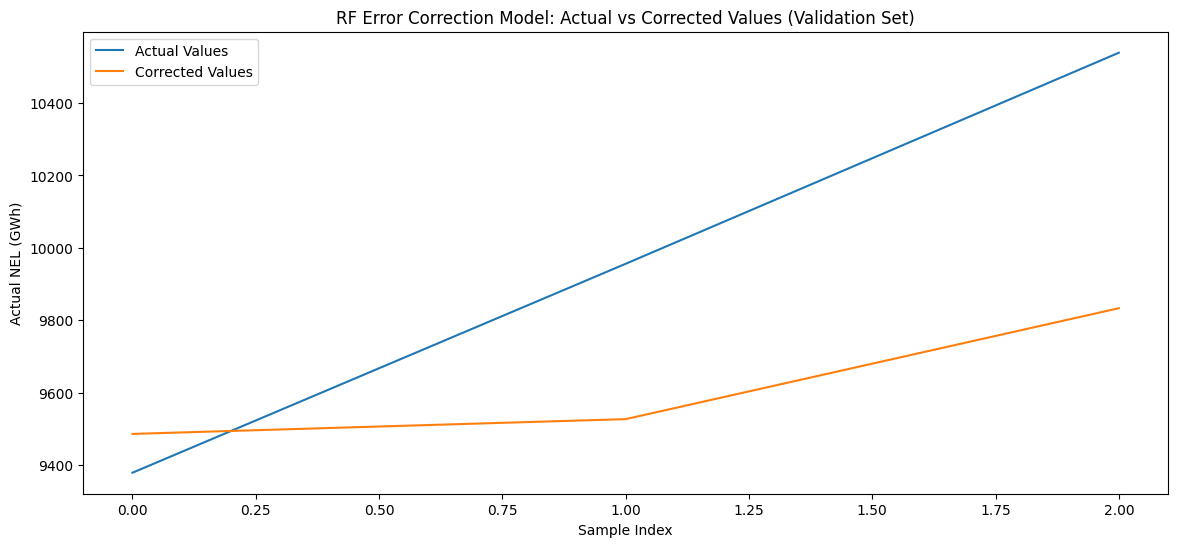

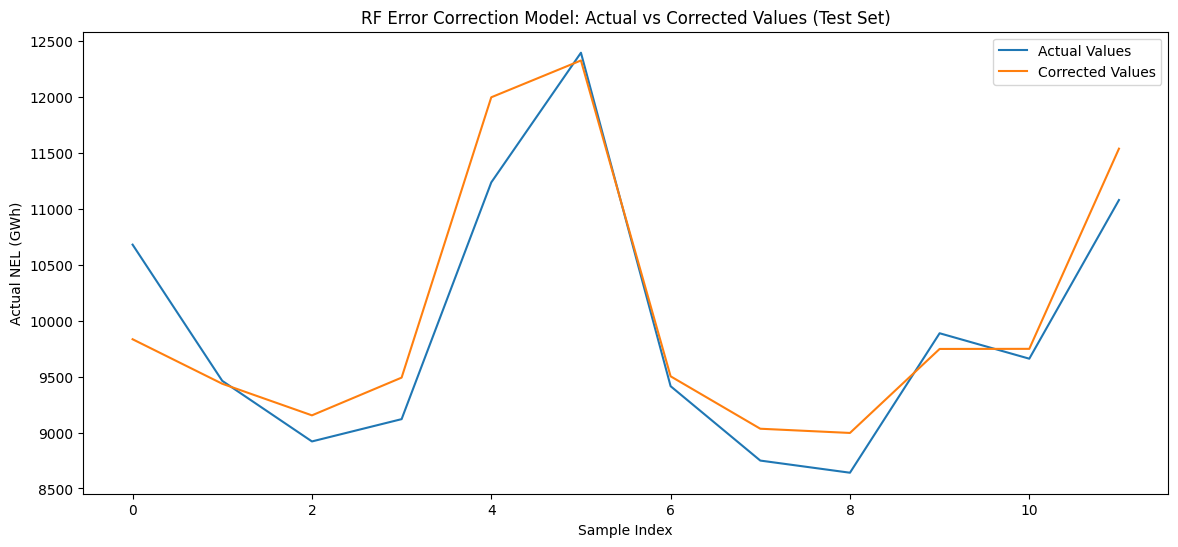

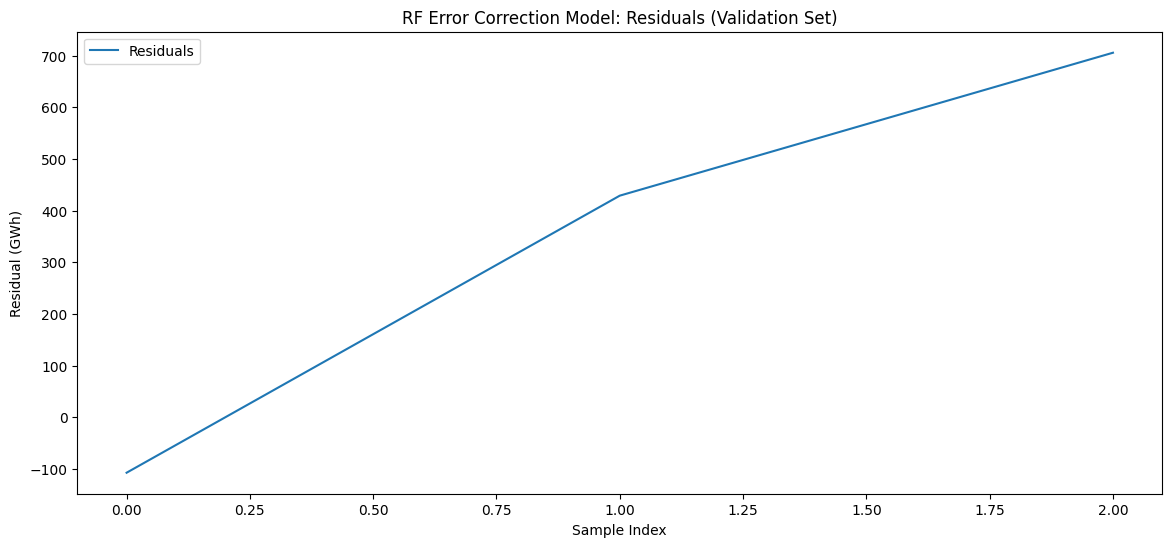

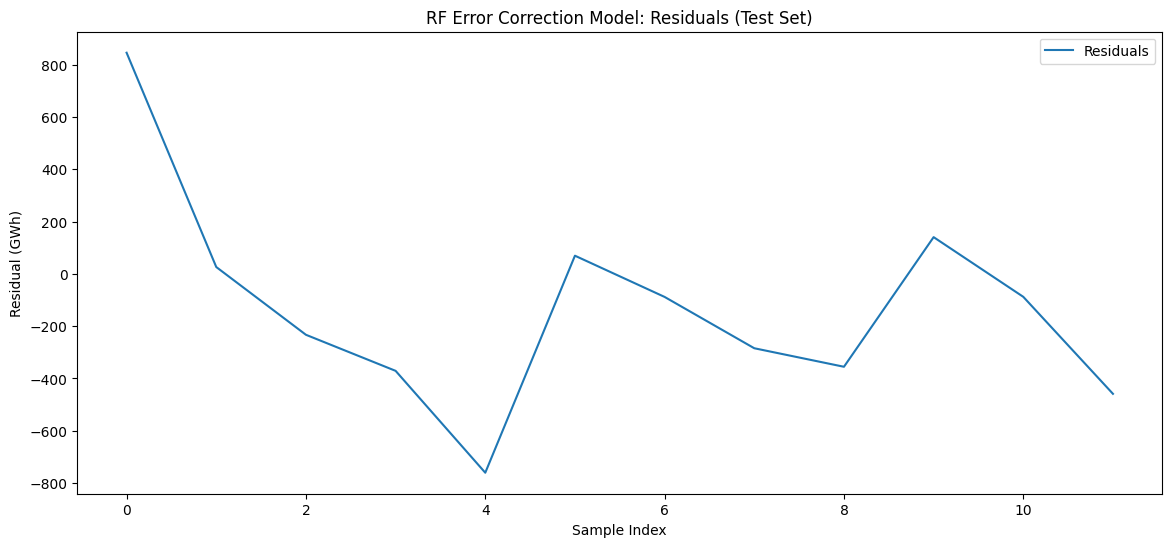

In [69]:
# Plot actual vs. predicted values for the validation set (Randomforesting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual Values')
plt.plot(y_val_forecast, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpVS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Randomforesting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_test_forecast, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpTS.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Randomforesting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values - y_val_forecast, label='Residuals')
plt.title('Random Foresting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrVS.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Forecasting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values - y_test_forecast, label='Residuals')
plt.title('Random Foresting Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrTS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (RF Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual Values')
plt.plot(y_val_corrected, label='Corrected Values')
plt.title('RF Error Correction Model: Actual vs Corrected Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFECMavpVS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (RF Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_test_corrected, label='Corrected Values')
plt.title('RF Error Correction Model: Actual vs Corrected Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFECMavpTS.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (RF Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values - y_val_corrected, label='Residuals')
plt.title('RF Error Correction Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFECMrVS.png'))
plt.show()
plt.close()

# Plot residuals for the test set (RF Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values - y_test_corrected, label='Residuals')
plt.title('RF Error Correction Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFECMrTS.png'))
plt.show()
plt.close()


In [70]:
from sklearn.ensemble import GradientBoostingRegressor

# Define parameter grid for GridSearchCV for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Gradient Boosting model
grid_search_gb = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                              param_grid=param_grid_gb,
                              cv=3,
                              n_jobs=-1,
                              verbose=2)

# Perform grid search for Gradient Boosting model
grid_search_gb.fit(X_train, y_train)

# Best hyperparameters for Gradient Boosting model
best_params_gb = grid_search_gb.best_params_
print(f'Best parameters for Gradient Boosting model: {best_params_gb}')

# Train the best Gradient Boosting model
best_gradientboosting_model = GradientBoostingRegressor(**best_params_gb, random_state=42)
best_gradientboosting_model.fit(X_train, y_train)

# Gradient Boosting model evaluation on validation set
y_val_gradientboost = best_gradientboosting_model.predict(X_val)
val_gradientboost_mae = mean_absolute_error(y_val, y_val_gradientboost)
val_gradientboost_mse = mean_squared_error(y_val, y_val_gradientboost)
val_gradientboost_mape = mean_absolute_percentage_error(y_val, y_val_gradientboost)
val_gradientboost_rmse = rmse(y_val, y_val_gradientboost)
val_gradientboost_r2 = r2_score(y_val, y_val_gradientboost)
val_gradientboost_mbd = mean_bias_deviation(y_val, y_val_gradientboost)
val_gradientboost_smape = smape(y_val, y_val_gradientboost)

print(f'Validation MAE (Gradient Boosting): {val_gradientboost_mae}')
print(f'Validation MSE (Gradient Boosting): {val_gradientboost_mse}')
print(f'Validation MAPE (Gradient Boosting): {val_gradientboost_mape}')
print(f'Validation RMSE (Gradient Boosting): {val_gradientboost_rmse}')
print(f'Validation R² (Gradient Boosting): {val_gradientboost_r2}')
print(f'Validation MBD (Gradient Boosting): {val_gradientboost_mbd}')
print(f'Validation sMAPE (Gradient Boosting): {val_gradientboost_smape}')

# Test the Gradient Boosting model
y_test_gradientboost = best_gradientboosting_model.predict(X_test)
test_gradientboost_mae = mean_absolute_error(y_test, y_test_gradientboost)
test_gradientboost_mse = mean_squared_error(y_test, y_test_gradientboost)
test_gradientboost_mape = mean_absolute_percentage_error(y_test, y_test_gradientboost)
test_gradientboost_rmse = rmse(y_test, y_test_gradientboost)
test_gradientboost_r2 = r2_score(y_test, y_test_gradientboost)
test_gradientboost_mbd = mean_bias_deviation(y_test, y_test_gradientboost)
test_gradientboost_smape = smape(y_test, y_test_gradientboost)

print(f'Test MAE (Gradient Boosting): {test_gradientboost_mae}')
print(f'Test MSE (Gradient Boosting): {test_gradientboost_mse}')
print(f'Test MAPE (Gradient Boosting): {test_gradientboost_mape}')
print(f'Test RMSE (Gradient Boosting): {test_gradientboost_rmse}')
print(f'Test R² (Gradient Boosting): {test_gradientboost_r2}')
print(f'Test MBD (Gradient Boosting): {test_gradientboost_mbd}')
print(f'Test sMAPE (Gradient Boosting): {test_gradientboost_smape}')

# Define parameter grid for GridSearchCV for Gradient Boosting
param_grid_gbec = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Gradient Boosting model
grid_search_gbec = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                              param_grid=param_grid_gbec,
                              cv=3,
                              n_jobs=-1,
                              verbose=2)

# Perform grid search for Gradient Boosting model
grid_search_gbec.fit(X_error_correction_train, y_error_correction_train)

# Best hyperparameters for Gradient Boosting model
best_params_gbec = grid_search_gbec.best_params_
print(f'Best parameters for Gradient Boosting model: {best_params_gbec}')

# Train the best Gradient Boosting model
best_gbec_model = GradientBoostingRegressor(**best_params_gbec, random_state=42)
best_gbec_model.fit(X_error_correction_train, y_error_correction_train)

# Gradient Boosting model evaluation on validation set
y_val_corrected_gb = best_gbec_model.predict(X_val)
val_corrected_gb_mae = mean_absolute_error(y_val, y_val_corrected_gb)
val_corrected_gb_mse = mean_squared_error(y_val, y_val_corrected_gb)
val_corrected_gb_mape = mean_absolute_percentage_error(y_val, y_val_corrected_gb)
val_corrected_gb_rmse = rmse(y_val, y_val_corrected_gb)
val_corrected_gb_r2 = r2_score(y_val, y_val_corrected_gb)
val_corrected_gb_mbd = mean_bias_deviation(y_val, y_val_corrected_gb)
val_corrected_gb_smape = smape(y_val, y_val_corrected_gb)

print(f'Validation MAE (GB Error Correction): {val_corrected_gb_mae}')
print(f'Validation MSE (GB Error Correction): {val_corrected_gb_mse}')
print(f'Validation MAPE (GB Error Correction): {val_corrected_gb_mape}')
print(f'Validation RMSE (GB Error Correction): {val_corrected_gb_rmse}')
print(f'Validation R² (GB Error Correction): {val_corrected_gb_r2}')
print(f'Validation MBD (GB Error Correction): {val_corrected_gb_mbd}')
print(f'Validation sMAPE (GB Error Correction): {val_corrected_gb_smape}')

# Test the Gradient Boosting model
y_test_corrected_gb = best_gb_model.predict(X_test)
test_corrected_gb_mae = mean_absolute_error(y_test, y_test_corrected_gb)
test_corrected_gb_mse = mean_squared_error(y_test, y_test_corrected_gb)
test_corrected_gb_mape = mean_absolute_percentage_error(y_test, y_test_corrected_gb)
test_corrected_gb_rmse = rmse(y_test, y_test_corrected_gb)
test_corrected_gb_r2 = r2_score(y_test, y_test_corrected_gb)
test_corrected_gb_mbd = mean_bias_deviation(y_test, y_test_corrected_gb)
test_corrected_gb_smape = smape(y_test, y_test_corrected_gb)

print(f'Test MAE (GB Error Correction): {test_corrected_gb_mae}')
print(f'Test MSE (GB Error Correction): {test_corrected_gb_mse}')
print(f'Test MAPE (GB Error Correction): {test_corrected_gb_mape}')
print(f'Test RMSE (GB Error Correction): {test_corrected_gb_rmse}')
print(f'Test R² (GB Error Correction): {test_corrected_gb_r2}')
print(f'Test MBD (GB Error Correction): {test_corrected_gb_mbd}')
print(f'Test sMAPE (GB Error Correction): {test_corrected_gb_smape}')


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters for Gradient Boosting model: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Validation MAE (Gradient Boosting): 81.02816934857583
Validation MSE (Gradient Boosting): 8267.764368359487
Validation MAPE (Gradient Boosting): 0.007976093344766804
Validation RMSE (Gradient Boosting): 90.92724766734935
Validation R² (Gradient Boosting): 0.963127549629095
Validation MBD (Gradient Boosting): 81.02816934857583
Validation sMAPE (Gradient Boosting): 0.8015804508284757
Test MAE (Gradient Boosting): 63.06689310008854
Test MSE (Gradient Boosting): 7479.429666164379
Test MAPE (Gradient Boosting): 0.006670060549659668
Test RMSE (Gradient Boosting): 86.4836959557371
Test R² (Gradient Boosting): 0.9939925990052784
Test MBD (Gradient Boosting): -32.16246313563139
Test sMAPE (Gradient Boosting): 0.663614212433596
Fitting 3 folds for each of 243 candidates, totalling 72

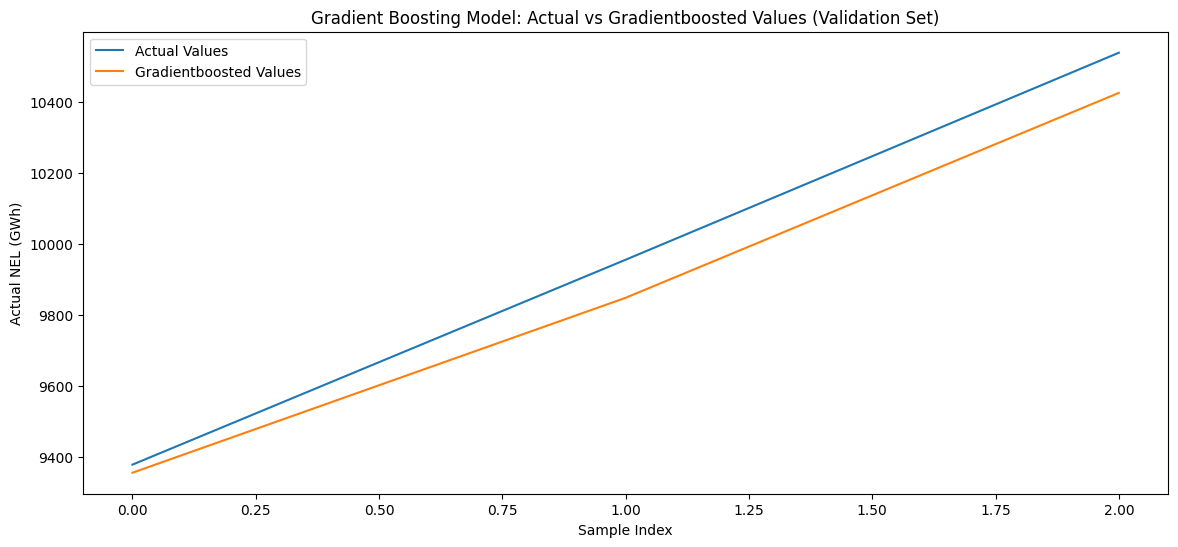

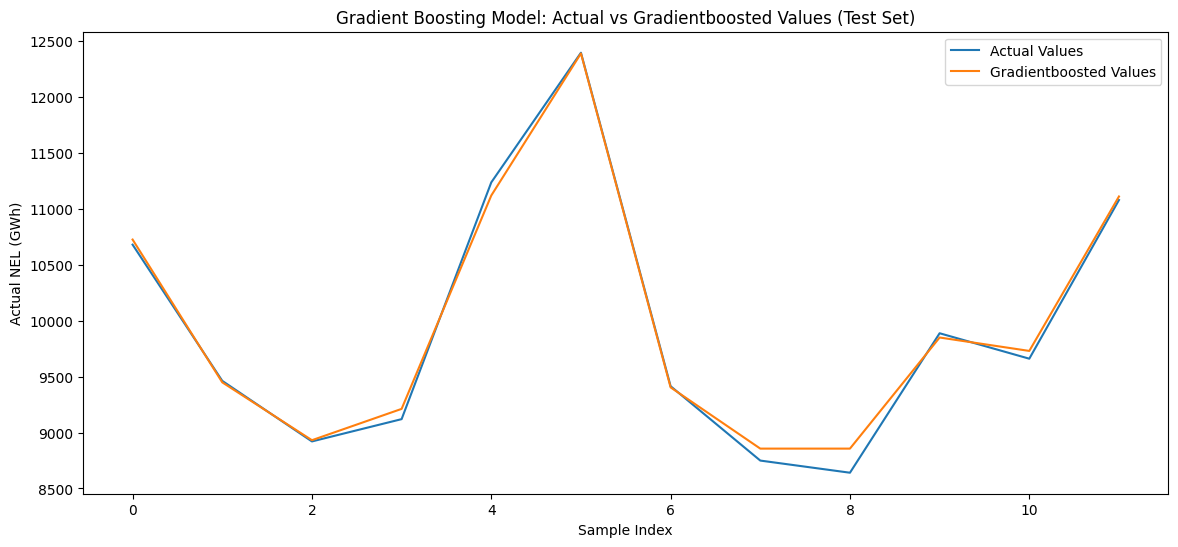

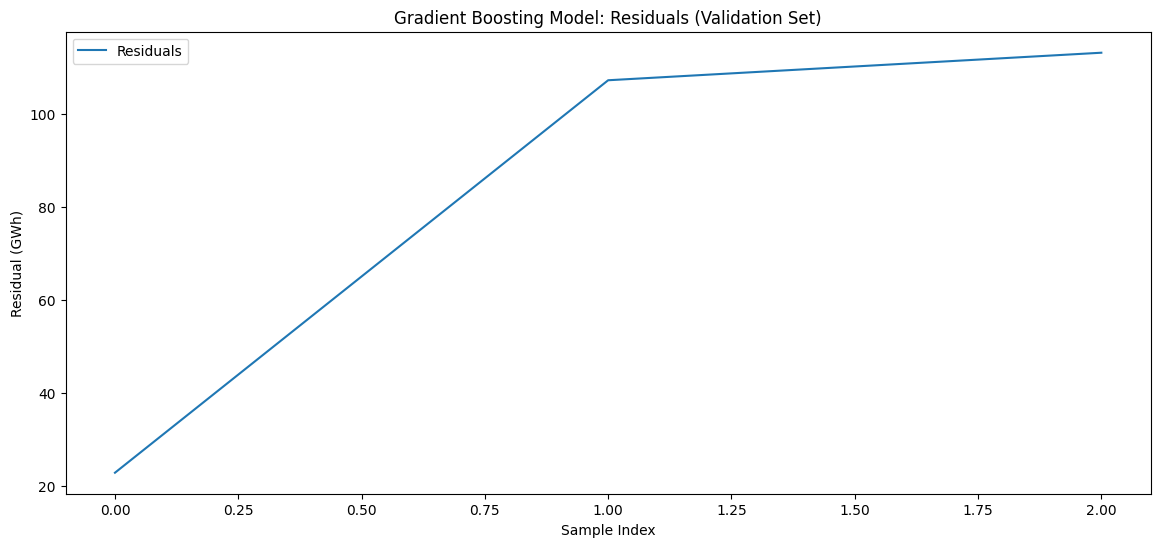

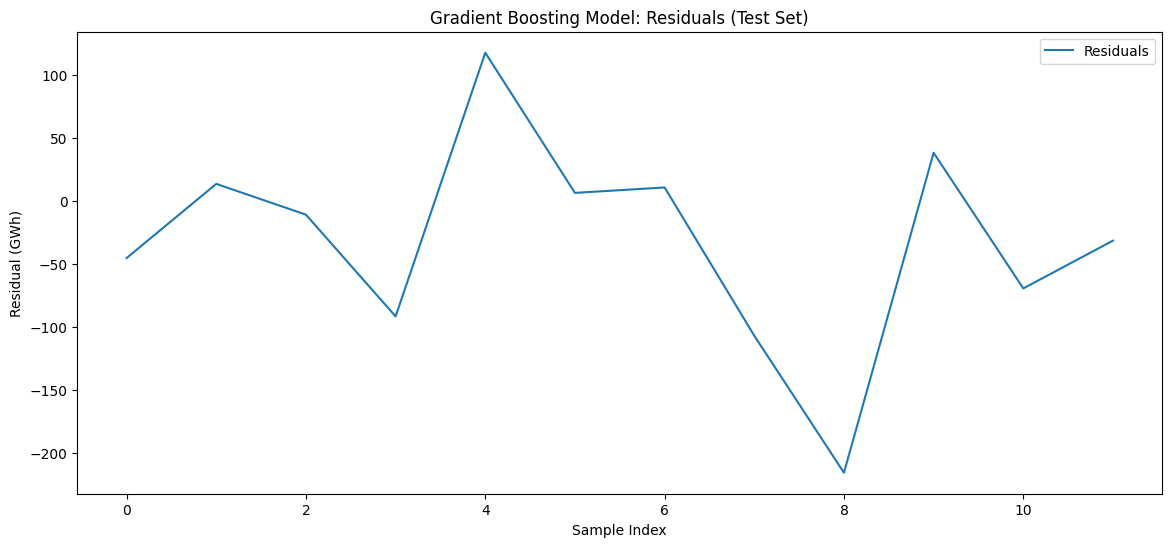

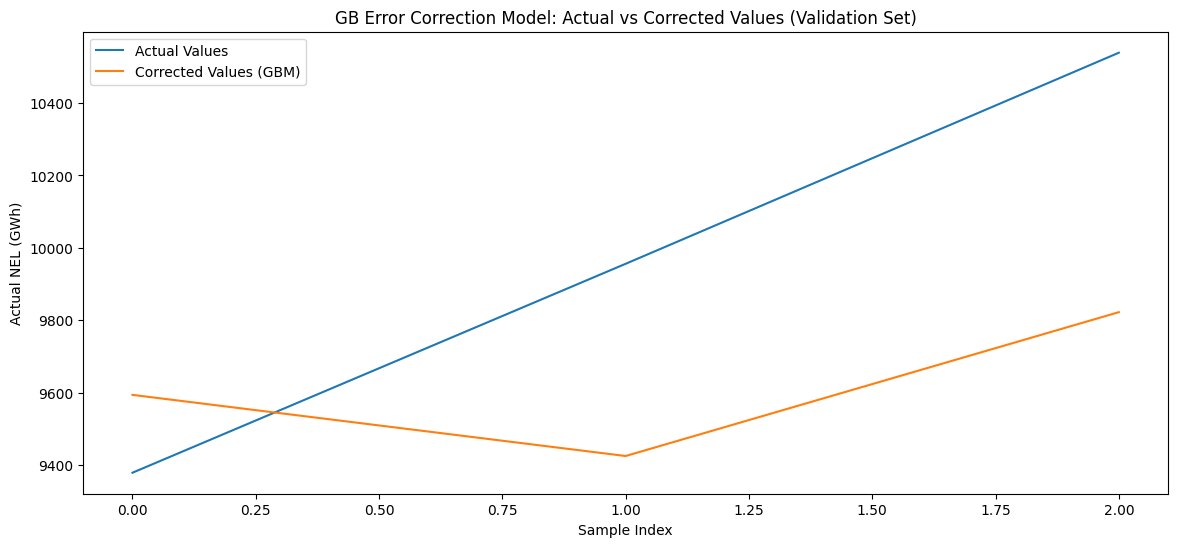

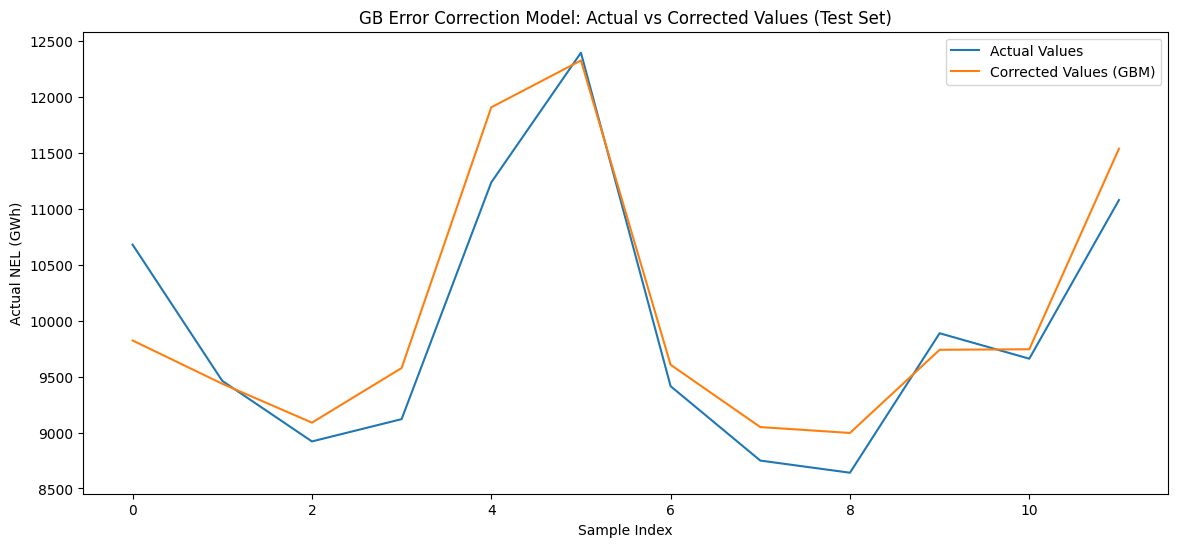

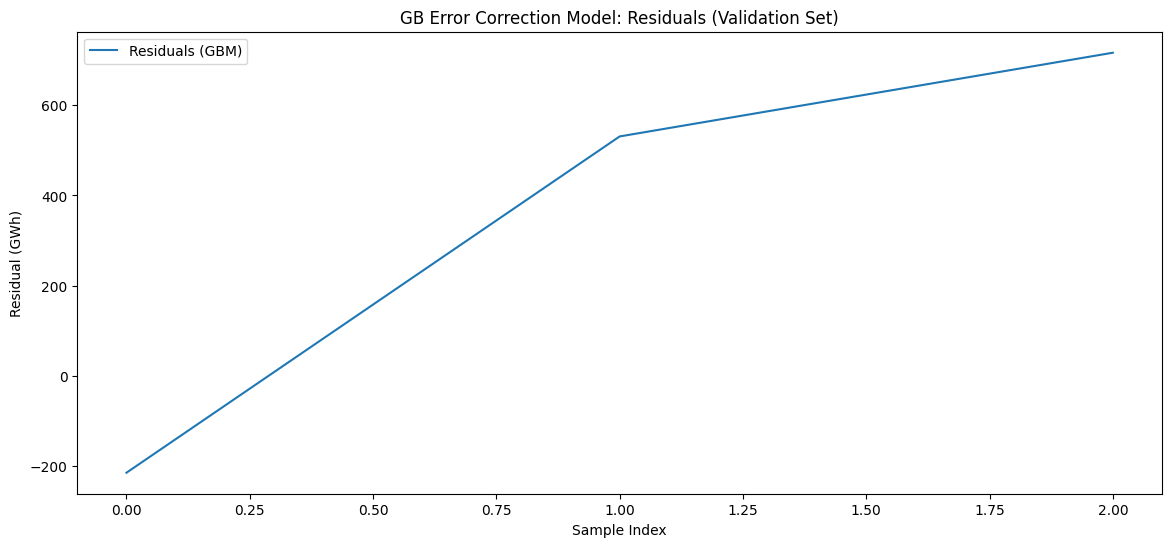

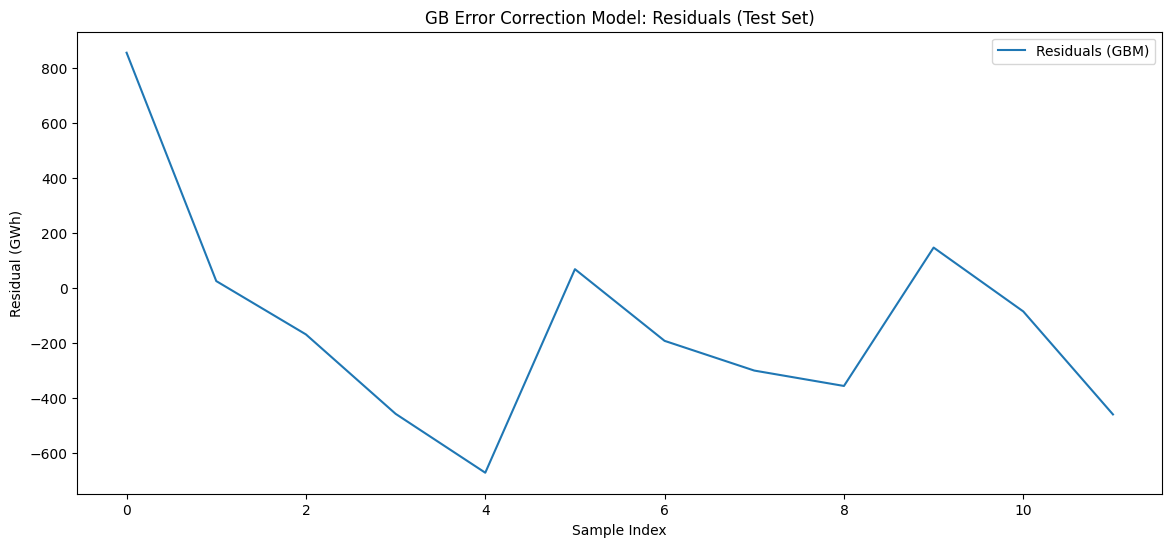

In [71]:
# Plot actual vs. predicted values for the validation set (Gradientboosting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual Values')
plt.plot(y_val_gradientboost, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpVS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Gradientboosting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_test_gradientboost, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpTS.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Gradientboosting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values - y_val_gradientboost, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrVS.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Gradientboosting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values - y_test_gradientboost, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrTS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (GB Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values, label='Actual Values')
plt.plot(y_val_corrected_gb, label='Corrected Values (GBM)')
plt.title('GB Error Correction Model: Actual vs Corrected Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBECMavpVS.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (GB Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_test_corrected_gb, label='Corrected Values (GBM)')
plt.title('GB Error Correction Model: Actual vs Corrected Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBECMavpTS.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (GB Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_val.values - y_val_corrected_gb, label='Residuals (GBM)')
plt.title('GB Error Correction Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBECMrVS.png'))
plt.show()
plt.close()

# Plot residuals for the test set (GB Error Correction Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values - y_test_corrected_gb, label='Residuals (GBM)')
plt.title('GB Error Correction Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBECMrTS.png'))
plt.show()
plt.close()

In [77]:
# Metrics for Random Forest Forecasting Model
rf_forecast_metrics = {
    'Model': 'Random Forest',
    'Task': 'Forecasting',
    'Validation MAE': val_forecast_mae,
    'Validation MSE': val_forecast_mse,
    'Validation MAPE': val_forecast_mape,
    'Validation RMSE': val_forecast_rmse,
    'Validation R²': val_forecast_r2,
    'Validation MBD': val_forecast_mbd,
    'Validation sMAPE': val_forecast_smape,
    'Test MAE': test_forecast_mae,
    'Test MSE': test_forecast_mse,
    'Test MAPE': test_forecast_mape,
    'Test RMSE': test_forecast_rmse,
    'Test R²': test_forecast_r2,
    'Test MBD': test_forecast_mbd,
    'Test sMAPE': test_forecast_smape
}

# Metrics for Random Forest Error Correction Model
rf_error_correction_metrics = {
    'Model': 'Random Forest',
    'Task': 'Error Correction',
    'Validation MAE': val_corrected_mae,
    'Validation MSE': val_corrected_mse,
    'Validation MAPE': val_corrected_mape,
    'Validation RMSE': val_corrected_rmse,
    'Validation R²': val_corrected_r2,
    'Validation MBD': val_corrected_mbd,
    'Validation sMAPE': val_corrected_smape,
    'Test MAE': test_corrected_mae,
    'Test MSE': test_corrected_mse,
    'Test MAPE': test_corrected_mape,
    'Test RMSE': test_corrected_rmse,
    'Test R²': test_corrected_r2,
    'Test MBD': test_corrected_mbd,
    'Test sMAPE': test_corrected_smape
}

In [78]:
# Metrics for Gradient Boosting Forecasting Model
gb_forecast_metrics = {
    'Model': 'Gradient Boosting',
    'Task': 'Forecasting',
    'Validation MAE': val_gradientboost_mae,
    'Validation MSE': val_gradientboost_mse,
    'Validation MAPE': val_gradientboost_mape,
    'Validation RMSE': val_gradientboost_rmse,
    'Validation R²': val_gradientboost_r2,
    'Validation MBD': val_gradientboost_mbd,
    'Validation sMAPE': val_gradientboost_smape,
    'Test MAE': test_gradientboost_mae,
    'Test MSE': test_gradientboost_mse,
    'Test MAPE': test_gradientboost_mape,
    'Test RMSE': test_gradientboost_rmse,
    'Test R²': test_gradientboost_r2,
    'Test MBD': test_gradientboost_mbd,
    'Test sMAPE': test_gradientboost_smape
}

# Metrics for Gradient Boosting Error Correction Model
gb_error_correction_metrics = {
    'Model': 'Gradient Boosting',
    'Task': 'Error Correction',
    'Validation MAE': val_corrected_gb_mae,
    'Validation MSE': val_corrected_gb_mse,
    'Validation MAPE': val_corrected_gb_mape,
    'Validation RMSE': val_corrected_gb_rmse,
    'Validation R²': val_corrected_gb_r2,
    'Validation MBD': val_corrected_gb_mbd,
    'Validation sMAPE': val_corrected_gb_smape,
    'Test MAE': test_corrected_gb_mae,
    'Test MSE': test_corrected_gb_mse,
    'Test MAPE': test_corrected_gb_mape,
    'Test RMSE': test_corrected_gb_rmse,
    'Test R²': test_corrected_gb_r2,
    'Test MBD': test_corrected_gb_mbd,
    'Test sMAPE': test_corrected_gb_smape
}

In [79]:
# Combine all metrics into a single DataFrame
all_metrics_df = pd.DataFrame([
    rf_forecast_metrics, rf_error_correction_metrics,
    gb_forecast_metrics, gb_error_correction_metrics
])

# Save to CSV
all_metrics_df.to_csv('model_comparison_metrics.csv', index=False)

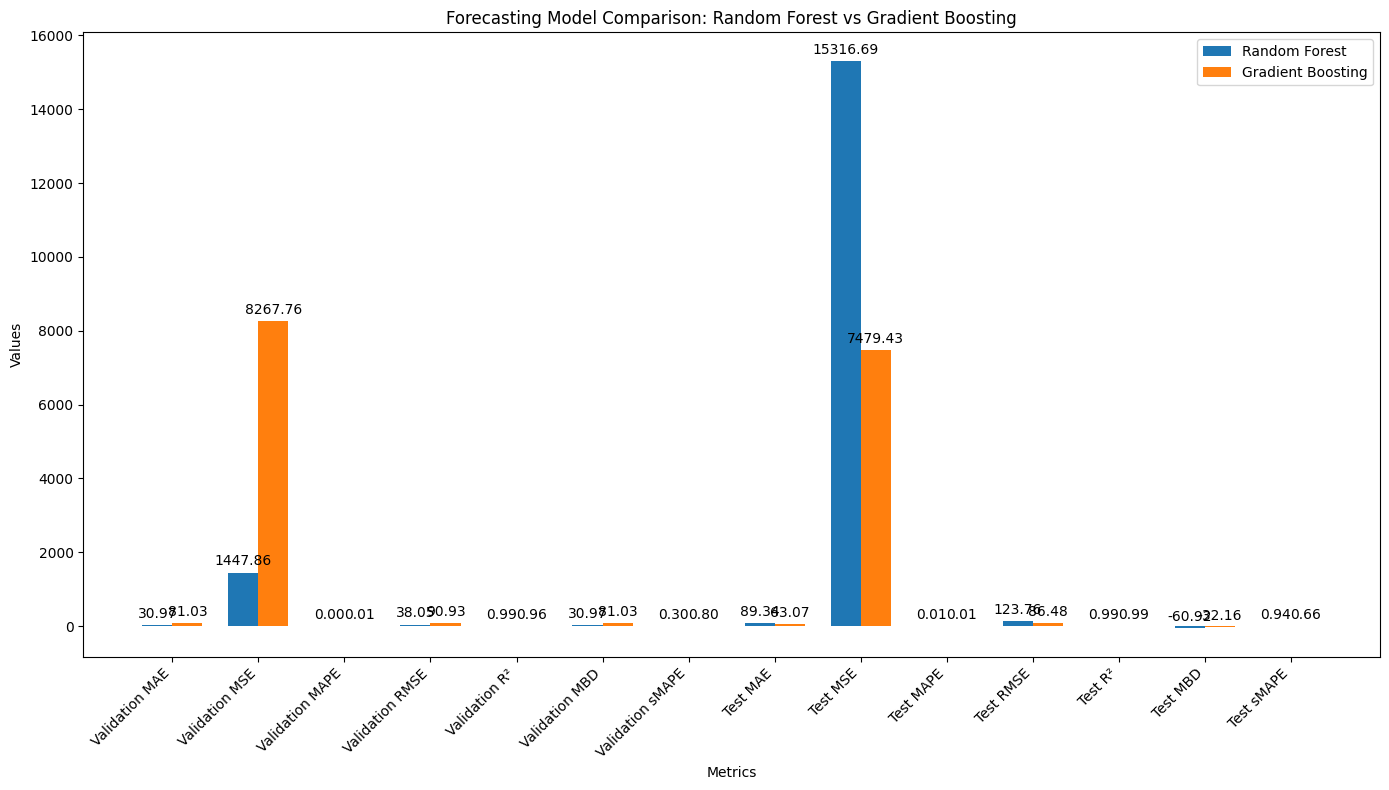

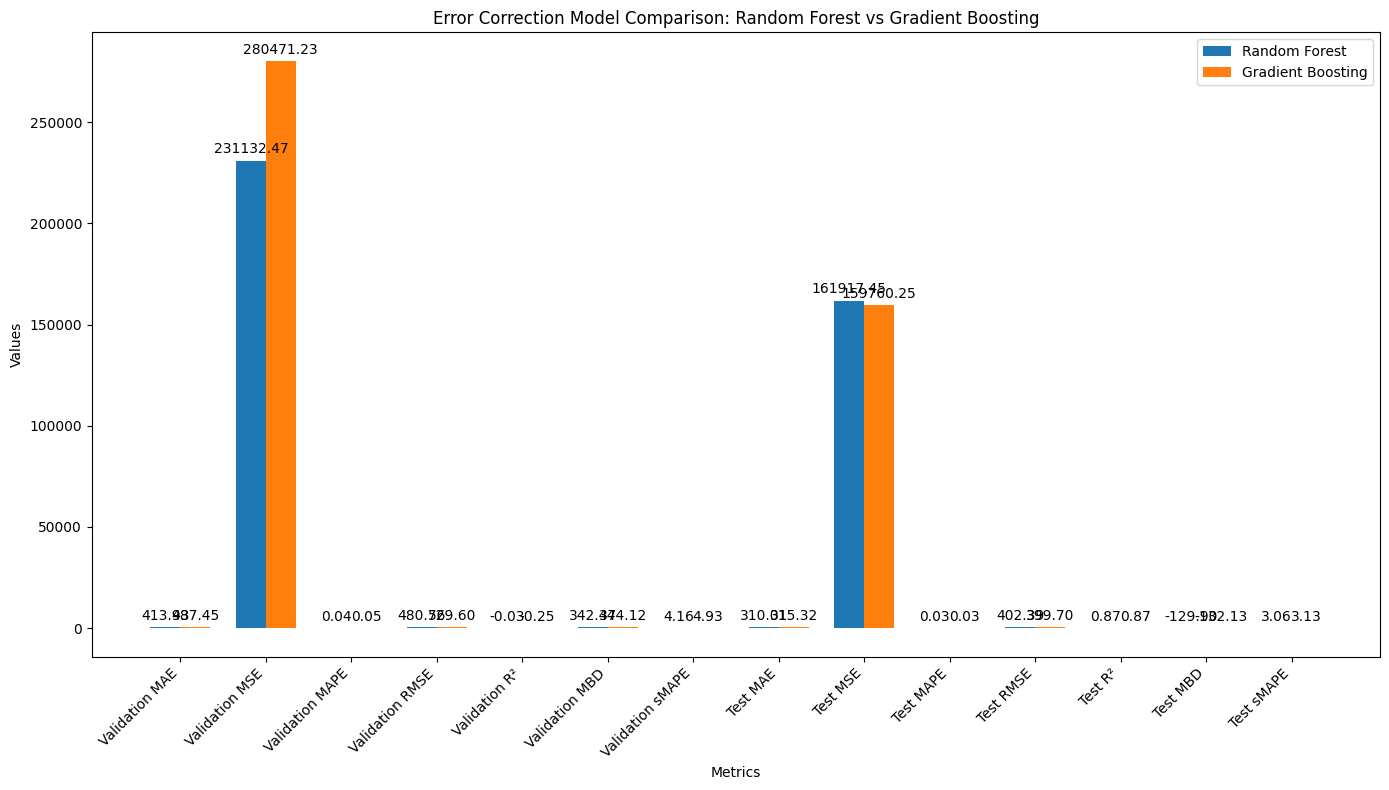

: 

In [84]:
# Load the saved metrics
loaded_metrics_df = pd.read_csv('model_comparison_metrics.csv')

# Filter data for plotting
forecasting_metrics = loaded_metrics_df[loaded_metrics_df['Task'] == 'Forecasting']
error_correction_metrics = loaded_metrics_df[loaded_metrics_df['Task'] == 'Error Correction']

# Plot comparison with values and save plots
def plot_metrics_comparison(df, task, filename):
    metrics = df.columns[2:]  # Exclude 'Model' and 'Task' columns
    models = df['Model']
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects1 = ax.bar(x - width/2, df.iloc[0, 2:], width, label=models.iloc[0])
    rects2 = ax.bar(x + width/2, df.iloc[1, 2:], width, label=models.iloc[1])
    
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(f'{task} Model Comparison: Random Forest vs Gradient Boosting')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.legend()
    
    # Annotate values on bars
    def annotate_bars(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    annotate_bars(rects1)
    annotate_bars(rects2)
    
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot and save forecasting metrics comparison
plot_metrics_comparison(forecasting_metrics, 'Forecasting', 'plots/fc_metrics_comparison.png')

# Plot and save error correction metrics comparison
plot_metrics_comparison(error_correction_metrics, 'Error Correction', 'plots/ec_metrics_comparison.png')